# ***Who Grade Binary Classification Evaluation***

This notebook shows the process of further evaluating the classification of samples into binary who grade (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [4]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics as s_metrics
from sklearn.dummy import DummyClassifier

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Consistency***
Next, let's make sure notebook is not random:

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [6]:
# Define path that contains the dhg dataset
DHG_PATH = "./DHG/"
# Define path that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define path to classification results
CLASSIFICATION__RESULT_PATH = (
    "../Results/binary_who_grade_classification/"
    "With scaling (min-max)/600 900"
)

### ***Reading MSI metadata file***

Next, let's read the metadata file:

In [7]:
# Read meta data csv
metadata_df = pd.read_csv(METADATA_PATH)

# Define binary classification label
metadata_df["label"] = (metadata_df["who_grade"] > 2).astype(int)

# Separate section and replica
s_metadata_df = metadata_df[metadata_df.sample_type == "section"]
r_metadata_df = metadata_df[metadata_df.sample_type == "replica"]

### ***Baseline models***

Next, let's see classification results from baseline models. We start from majority/minority vote:

In [8]:
# Create metric list to store values
metrics = []

# Loop over dummy strategies
for strategy in ["most_frequent", "constant"]:
  # Loop over section/replica
  for loop_metadata_df in [s_metadata_df, r_metadata_df]:
    # Dont affect original data frame
    loop_metadata_df = loop_metadata_df.copy()

    # Initialize prediction column
    loop_metadata_df["prediction"] = -1

    # Leave one image out
    for exclude_image, group in loop_metadata_df.groupby("file_name"):
      # Get all spectra's in the exclude_image to exclude them - Leave one
      # image out
      exclude_images = loop_metadata_df["file_name"].isin(
          group.file_name.to_list()
      )

      # Get all spectra's that are from the same patient as patients in
      # exclude_image - Leave one patient out
      exclude_patients = loop_metadata_df["sample_number"].isin(
          group.sample_number.to_list()
      )

      # Get train data
      X_train = loop_metadata_df.loc[~(exclude_images | exclude_patients),
                                     loop_metadata_df.columns != "label"]
      y_train = loop_metadata_df.loc[~(exclude_images | exclude_patients),
                                     "label"]

      # Get test data
      X_test = loop_metadata_df.loc[exclude_images,
                                    loop_metadata_df.columns != "label"]
      y_test = loop_metadata_df.loc[exclude_images, "label"]

      # Get minority class
      minority_class = 0 if (y_train == 0).sum() < (y_train == 1).sum() else 1

      # Train dummy classifier on train data
      clf = DummyClassifier(
          strategy=strategy, random_state=SEED, constant=minority_class
      ).fit(X_train, y_train)

      # Predict on test data
      loop_metadata_df.loc[exclude_images, "prediction"] = clf.predict(X_test)

    # Calculate Roc Curve
    fpr, tpr, thresholds = s_metrics.roc_curve(
        loop_metadata_df.label, loop_metadata_df.prediction
    )

    # Append all metrics to list
    metrics.append(
        [
            round(
                s_metrics.accuracy_score(
                    loop_metadata_df.label, loop_metadata_df.prediction
                ), 3
            ),
            round(
                s_metrics.balanced_accuracy_score(
                    loop_metadata_df.label, loop_metadata_df.prediction
                ), 3
            ),
            round(
                s_metrics.precision_score(
                    loop_metadata_df.label, loop_metadata_df.prediction
                ), 3
            ),
            round(
                s_metrics.recall_score(
                    loop_metadata_df.label, loop_metadata_df.prediction
                ), 3
            ),
            round(
                s_metrics.f1_score(
                    loop_metadata_df.label, loop_metadata_df.prediction
                ), 3
            ),
            round(s_metrics.auc(fpr, tpr), 3),
            round(
                s_metrics.average_precision_score(
                    loop_metadata_df.label, loop_metadata_df.prediction
                ), 3
            )
        ]
    )

# Print dummy baseline metrics
pd.DataFrame(
    metrics, index=[
        "Section majority Class", "Replica majority Class",
        "Section minority Class", "replica minority Class"
    ], columns=[
        "Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1-Score",
        "ROC-AUC", "Average Precision"
    ]
)

c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Average Precision
Section majority Class,0.64,0.5,0.64,1.0,0.78,0.5,0.64
Replica majority Class,0.60,0.5,0.60,1.0,0.75,0.5,0.60
Section minority Class,0.36,0.5,0.00,0.0,0.00,0.5,0.64
replica minority Class,0.40,0.5,0.00,0.0,0.00,0.5,0.60


Next, let's use binomial sampling as a baseline:

In [9]:
# Create metric lists to store values
metrics_mean = []
metrics_std = []

# Loop over sampling strategies
for strategy in ["Equal probability", "Class prior probability"]:
  # Loop over section/replica
  for loop_metadata_df in [s_metadata_df, r_metadata_df]:
    # Dont affect original data frame
    loop_metadata_df = loop_metadata_df.copy()

    # Probability of class 1
    p_1 = 0.5 if strategy == "Equal probability" else (
        loop_metadata_df.label == 1
    ).sum() / loop_metadata_df.shape[0]

    # Sample from binomial using class probability
    rand = np.random.binomial(1, p=p_1, size=(10000, loop_metadata_df.shape[0]))

    # Create scores lists to store metric values for each random sample
    scores = []

    # Loop over each random sample to calculate metrics
    for sample in rand:
      # Calculate Roc Curve
      fpr, tpr, thresholds = s_metrics.roc_curve(loop_metadata_df.label, sample)
      # Append all metrics to list
      scores.append(
          [
              round(
                  s_metrics.accuracy_score(loop_metadata_df.label, sample), 3
              ),
              round(
                  s_metrics.balanced_accuracy_score(
                      loop_metadata_df.label, sample
                  ), 3
              ),
              round(
                  s_metrics.precision_score(loop_metadata_df.label, sample), 3
              ),
              round(s_metrics.recall_score(loop_metadata_df.label, sample), 3),
              round(s_metrics.f1_score(loop_metadata_df.label, sample), 3),
              round(s_metrics.auc(fpr, tpr), 3),
              round(
                  s_metrics.average_precision_score(
                      loop_metadata_df.label, sample
                  ), 3
              )
          ]
      )

    # Append mean and standard deviation of all random sample metrics
    metrics_mean.append(np.round(np.mean(scores, axis=0), 3))
    metrics_std.append(np.round(np.std(scores, axis=0), 3))

# Create single metric value from mean and standard deviation
metrics = [
    [str(mean_i) + " +- " + str(std_i)
     for mean_i, std_i in zip(mean, std)]
    for mean, std in zip(metrics_mean, metrics_std)
]

# Print baseline metrics
pd.DataFrame(
    metrics, index=[
        "Section equal probability", "Replica equal probability",
        "Section class prior probability", "Replica class prior probability"
    ], columns=[
        "Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1-Score",
        "ROC-AUC", "Average Precision"
    ]
)

,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,ROC-AUC,Average Precision
Section equal probability,0.501 +- 0.101,0.501 +- 0.105,0.641 +- 0.103,0.502 +- 0.124,0.557 +- 0.106,0.501 +- 0.105,0.648 +- 0.05
Replica equal probability,0.5 +- 0.1,0.5 +- 0.102,0.6 +- 0.104,0.501 +- 0.129,0.541 +- 0.109,0.5 +- 0.102,0.608 +- 0.05
Section class prior probability,0.539 +- 0.095,0.499 +- 0.099,0.639 +- 0.075,0.641 +- 0.121,0.636 +- 0.088,0.499 +- 0.099,0.645 +- 0.046
Replica class prior probability,0.52 +- 0.097,0.501 +- 0.099,0.601 +- 0.084,0.599 +- 0.126,0.596 +- 0.095,0.501 +- 0.099,0.607 +- 0.049


### ***Section/replica classification comparison***

Next, let's see classification results from section/replica in the metrics we care about (confusion matrix, ROC-AUC, balanced accuracy):

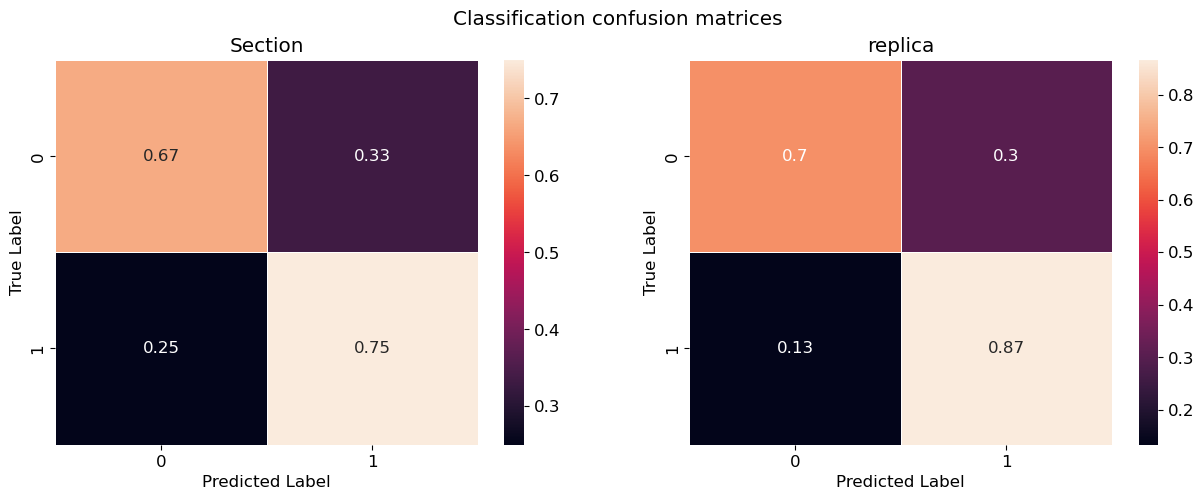

In [10]:
# Get section real and predicted labels
s_spectra_wise_results = pd.read_csv(
    (
        f"{CLASSIFICATION__RESULT_PATH}/"
        "section_section_tissue_spectra_wise_predictions.csv"
    )
)
s_img_wise_results = s_spectra_wise_results.groupby("file_name"
                                                   ).aggregate("mean")
s_real_labels = s_img_wise_results["label"]
s_pred_labels = s_img_wise_results["prediction"]

# Get Replica real and predicted labels
r_spectra_wise_results = pd.read_csv(
    (
        f"{CLASSIFICATION__RESULT_PATH}/"
        "replica_replica_tissue_spectra_wise_predictions.csv"
    )
)
r_img_wise_results = r_spectra_wise_results.groupby("file_name"
                                                   ).aggregate("mean")
r_real_labels = r_img_wise_results["label"]
r_pred_labels = r_img_wise_results["prediction"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Plot section confusion matrix
cf_matrix = s_metrics.confusion_matrix(
    s_real_labels, (s_pred_labels > 0.5).astype(int), normalize="true"
)
ax = sns.heatmap(cf_matrix, annot=True, linewidths=0.5, ax=axes[0])
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
ax.set_title("Section")

# Plot replica confusion matrix
cf_matrix = s_metrics.confusion_matrix(
    r_real_labels, (r_pred_labels > 0.5).astype(int), normalize="true"
)
ax = sns.heatmap(cf_matrix, annot=True, linewidths=0.5, ax=axes[1])
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
ax.set_title("replica")

# Display plot
fig.suptitle("Classification confusion matrices")
plt.show()

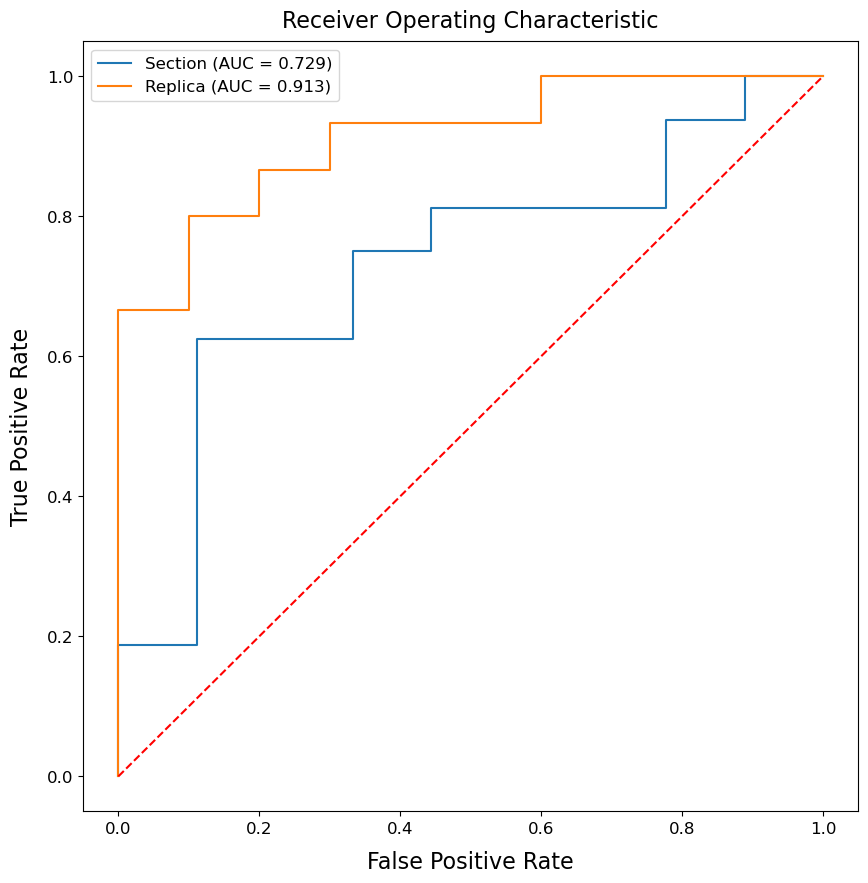

In [11]:
# Define figure size
plt.figure(figsize=(10, 10))

# Compute Receiver operating characteristic + AUC for section
fpr, tpr, thresholds = s_metrics.roc_curve(s_real_labels, s_pred_labels)
roc_auc = s_metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Section (AUC = {roc_auc:.3f})")

# Compute Receiver operating characteristic + AUC for replica
fpr, tpr, thresholds = s_metrics.roc_curve(r_real_labels, r_pred_labels)
roc_auc = s_metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Replica (AUC = {roc_auc:.3f})")

# Plot
plt.legend(loc="upper left")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.show()

In [12]:
# Compute balanced accuracy for section
s_balanced_accuracy = s_metrics.balanced_accuracy_score(
    s_real_labels, (s_pred_labels > 0.5).astype(int)
)

# Compute balanced accuracy for replica
r_balanced_accuracy = s_metrics.balanced_accuracy_score(
    r_real_labels, (r_pred_labels > 0.5).astype(int)
)

# Display values
print(f"Section balanced accuracy {round(s_balanced_accuracy, 3)}")
print(f"Section balanced accuracy {round(r_balanced_accuracy, 3)}")

Section balanced accuracy 0.708
Section balanced accuracy 0.783


In [13]:
print("Section misclassified:", s_real_labels[(s_real_labels != (s_pred_labels > 0.5).astype(int))].index.to_list())
print("Replica misclassified:", r_real_labels[(r_real_labels != (r_pred_labels > 0.5).astype(int))].index.to_list())

Section misclassified: ['HG 10-s', 'HG 15-s', 'HG 16-s', 'HG 2-s', 'HG 20-s', 'HG 21-s', 'HG 9-s']
Replica misclassified: ['HG 19-r', 'HG 20-r', 'HG 21-r', 'HG 29-r', 'HG 3-r']
